*Parameter cells and Devices cells must be executed for any of the sections

# Parameters

In [ ]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
#Video and animations requirements
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)
length_units = "um"

def default_solution(device,file_name,type_of_solution,vector_potential=None,terminal_currents_applied=None):
    '''
    Esta función se usa para implementar las opciones y el solver de tdgl para los posibles casos existentes.
    device: tdgl.device object
    type_of_solution: String
    vector_potential: Double
    terminal_currents: unidimensional array [source_current,drain_current]
    Depending on the type_of_solution a solution is implemented
    '''
    solution = None
    options = tdgl.SolverOptions(
    skip_time=100,  # initial relaxation time
    solve_time=150,  # Real simulation time
    output_file=os.path.join(tempdir.name, file_name),  # file route
    field_units="mT",  #Units of the applied field (miliTesla)
    current_units="uA",  # Units of the applied current (microamperios)
    save_every=100,  # Time interval between saves
    )
    if type_of_solution == "0_field_0_current" or type_of_solution == "0_current_0_field":
        solution = tdgl.solve(
        device,
        options
        )
    elif type_of_solution == "0_current": 
        solution = tdgl.solve(
        device,
        options,
        applied_vector_potential=vector_potential
        )   
    elif type_of_solution == "0_field":
         solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]) 
        )
    else :
        solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]),
         applied_vector_potential=vector_potential
        )
    return solution
  
    

In [ ]:
# ====================================================
# Default configuration
# ====================================================
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [ ]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = 0.5           
london_lambda = 2  
d = 0.1               
gamma = 10             


###Main rectangle
width_x = 14 
height_y = width_x-2  
  # Ancho del puente (dimensión x)
 # Alto del puente (dimensión y)
contact_size = width_x
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 = height_y/2

### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 2
MAX_EDGE_LENGTH_VORTEX = xi / 2
SMOOTHING_STEPS = 100            
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{height_y2-2}' )

# Device 

Device and mesh creation

In [ ]:
def create_device(geometry_used,max_edge_length,increment=3,translationx=((width_x + width_x2 + STRIPE_LENGTH) / 2),translationy=0):
    '''
    Since we're using the same geometry, this function is implemented so we can change the position of the source and drain to our liking
    geometry_used: tdgl.polygon object,
    max_edge_length:int,
    source_dimension: array [width,height]
    drain_dimension: array [width,height]
    translationx:float
    translationy:float
    The translations move the source and drain along the polygon
    '''
    #for points that are the same as the  film width
    contact_size = width_x #1 µm squares
    film_poly_up = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=increment)).translate(dx=+width_x/2)
    combined_geometry = film_poly.union(geometry_used,film_poly_up)
    #Source
    source_poly = tdgl.Polygon(
        "source", 
        points=box(width=STRIPE_LENGTH,height=height_y2)
    ).translate(dx=-translationx).translate(dy=translationy)
    #Drain 
    drain_poly = tdgl.Polygon(
        "drain", 
        points=box(width=STRIPE_LENGTH, height=increment)
    ).translate(dx=+translationx).translate(dy=+translationy)
    combined_film = tdgl.Polygon.from_union([combined_geometry, source_poly, drain_poly], name="film")
    probe_points = [(width_x / 3,0), (-width_x / 3,0)]
    device = tdgl.Device(
        "vertical_bridge",
        layer=layer,
        film=combined_film,
        holes=[],
        terminals=[source_poly, drain_poly],
        probe_points=probe_points,
        length_units=LENGTH_UNITS,
    )
    
    device.make_mesh(max_edge_length=max_edge_length, smooth=SMOOTHING_STEPS)
    #Remove to se more details about the mesh 
    #There are 4 malformed cells as of now , 4/5030 
    clear_output(wait=True)
    print(f"  Malla creada: {len(device.mesh.sites)} puntos")
    fig, ax = device.draw()
    return device
device_fast = create_device(half_geometry,MAX_EDGE_LENGTH_IV)
fig, ax = device_fast.plot(mesh=True)

# Simulations

## 1) Zero field for a fixed current

In [33]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5","0_field",terminal_currents_applied=[28,-28])

Simulating: 100%|██████████████████████| 150/150 [05:51<00:00,  2.35s/tau ]


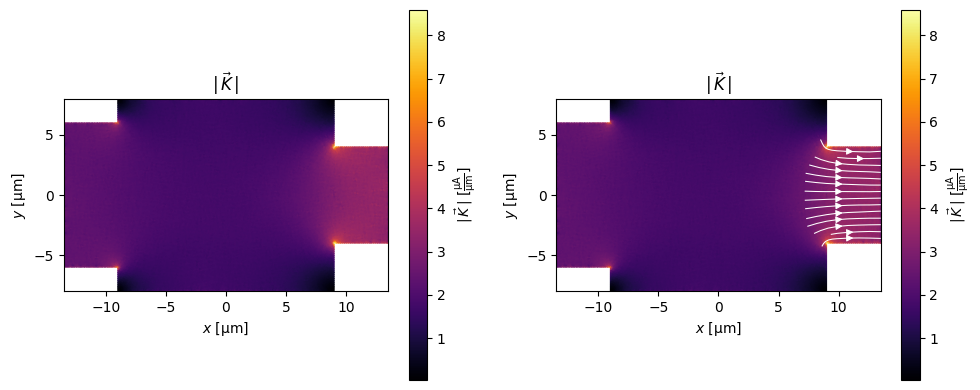

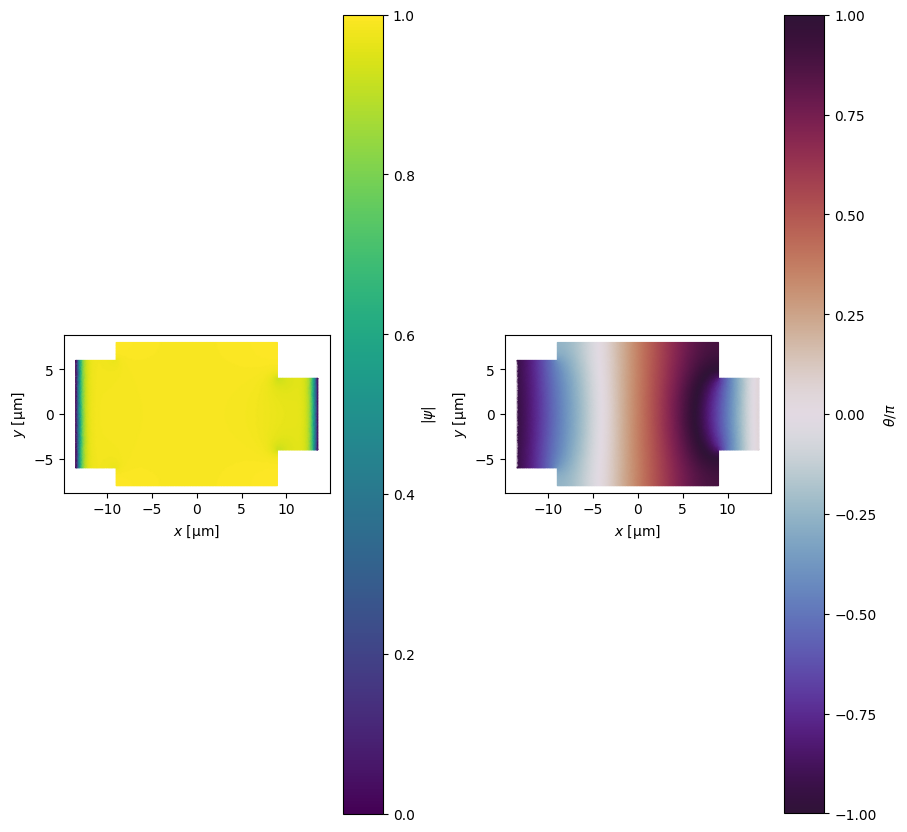

In [34]:
# Create figure with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
# Plot the currents
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Evaluate sheet current density at cross-section
x = np.linspace(-width_x / 2, width_x / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T

plt.tight_layout()  # Automatically adjusts subplots to fit in figure
plt.show()
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 155
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 10))
plt.show()

## 2) Zero field with varying currents

Functions and currents

In [35]:
def aplicacion_corriente(device,currents,direction):
    voltages = []
    direction = "left_to_right"
    if direction == "left_to_right":
        sign1 = 1
        sign2 = -1
    elif direction == "right_to_left":
        sign1 = -1
        sign2 = 1
    else:
        print("please enter a valid direction: left_to_right or right_to_left")
        return None 
    # =========================================================
    # Simulation
    # =========================================================
    start_time = time.time()
    total_simulations = len(currents)
    j=0
    for I in currents:
        solution = default_solution(
            device_fast,
            f"solution_I_{I:.1f}.h5",
            "0_field",
            terminal_currents_applied=[I * sign1, I * sign2])
        dynamics = solution.dynamics
        indices = dynamics.time_slice(tmin=120)
        voltage = np.abs(np.mean(dynamics.voltage()[indices]))
        voltages.append(voltage)
        j+=1
        print(f"I = {I:.1f} µA, <V> = {voltage:.4f} V₀,progress: {np.round(j/np.size(currents)*100,2)}%", end='\r')
    
  
    clear_output(wait=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(" " * 60, end='\r') 
    print("-" * 50)
    print(f"✅ The simulation was completed with {total_simulations} steps.")
    print(f"⏱️ The elapsed time was: {elapsed_time:.2f} seconds.")
    print(f"📊 Tiempo mean time per step was: {(elapsed_time / total_simulations):.2f} seconds.")
    print("-" * 50)
    return voltages
def plot_currents(currents,voltages,direction,plot_type="plot",color_applied="teal"):
    plt.figure(figsize=(6, 4))
    if plot_type == "plot":
        plt.plot(currents, voltages, "o-", color=color_applied)
    elif plot_type == "scatter":
        plt.scatter(currents,voltages, "o-", color=color_applied)
    else:
        print("insert a valid plot type")
        return None
    plt.xlabel("Corriente $I$ [$\mu$A]")
    plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")
    plt.title(f'Curva Voltaje vs Corriente (0–15 µA) de {direction}')
    plt.grid(True)
    plt.show()
    plt.savefig("primer_intento.jpg")
Lcurrents = np.arange(-15, 0, 0.5)  # from 20 to 35 µA, step: 0.5
Rcurrents = np.arange(0,15, 0.5) 
total_currents= np.concatenate((Lcurrents,Rcurrents))

<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alejo\AppData\Local\Temp\ipykernel_29692\4133456559.py:52: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Corriente $I$ [$\mu$A]")
C:\Users\alejo\AppData\Local\Temp\ipykernel_29692\4133456559.py:53: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")


#### 2.1) Simulation with the default device

In [ ]:
voltagesl = aplicacion_corriente(device_fast,Lcurrents,"left_to_right")
voltagesr = aplicacion_corriente(device_fast,Rcurrents,"right_to_left")
voltagesl=np.multiply(voltagesl,-1)
voltagesr = np.multiply(voltagesr,-1)
plot_currents(Lcurrents,voltagesl,"left to right ")
plot_currents(Rcurrents,voltagesr,"right to left")
total_voltages=np.concatenate((voltagesl,voltagesr))
plot_currents(total_currents,total_voltages,"complete")


Simulating: 100%|█████████████████████▉| 150/150 [05:34<00:00,  2.23s/tau ]


I = -15.0 µA, <V> = 0.0000 V₀,progress: 3.33%

Simulating: 100%|█████████████████████▉| 150/150 [05:42<00:00,  2.28s/tau ]


I = -14.5 µA, <V> = 0.0000 V₀,progress: 6.67%

Simulating: 100%|█████████████████████▉| 150/150 [05:39<00:00,  2.27s/tau ]


I = -14.0 µA, <V> = 0.0000 V₀,progress: 10.0%

Simulating: 100%|█████████████████████▉| 150/150 [05:36<00:00,  2.25s/tau ]


I = -13.5 µA, <V> = 0.0000 V₀,progress: 13.33%

Thermalizing:   4%|▉                     | 4/100 [00:26<07:08,  4.47s/tau ]

### 2.2) Zero field with varying currents and device modifications

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{height_y2-2}' )
delta = 3

In [ ]:
#de 9 a 3 
io = 3
if = height_y2
size = if - io +1
voltages_arri = np.empty(size)
voltages_arrd = np.empty(size)
voltages_totalArr = np.empty(size)
J = 0
for i in range(io,if):
    deltay = i
    device_fast_2  = create_device(half_geometry,MAX_EDGE_LENGTH_IV,difference=deltay)
    fig, ax = device_fast_2.draw()
    voltages_i = aplicacion_corriente(device_fast_2,Lcurrents,"left_to_right")
    voltages_d = aplicacion_corriente(device_fast_2,Rcurrents,direction2,"right_to_left")
    voltages_i =  np.multiply(voltages2i,-1)
    voltages_d = np.multiply(voltages2d,-1)
    voltages_arri[i] = voltages_i
    voltages_arrd[i] = voltages_d 
    total_voltages=np.concatenate((voltages_2i,voltages_2d))
    voltages_totalArr[i] = total_voltages
    plot_currents(total_currents,total_voltages_2,"complete")
    J+= 1
    print(f'progress: {np.round((J/size)*100,3)}')

   

## 3)Applied field

In [ ]:
from tdgl.sources import ConstantField
# =========================
# 2) Material parameters
# =========================
d = 0.1  # Superconductor depth in micrometers (µm)
area_fast = np.sum(device_fast.areas)  # effective area of the device ( µm²)
# =========================
# 3) External Field sweep
# =========================
# Defines a list of 100 values for the external magnetic field form 0 to 1 mT
campos_fast = np.linspace(0.0, 2, 100)  # External field on mT (B)
momentos_fast = [] #total magnetic moment
magnetizaciones_fast = []  # volumetric magnetization
# Loop for each value of B
for B in campos_fast:
    # Creates a uniform magnetic field of magnitude B
    campo_ext = ConstantField(B, field_units=options.field_units, length_units=device_fast.length_units)
    # Solves Ginzburg–Landau equations with an applied field
    solucion = default_solution(device_fast,"Bscan.h5"," ",vector_potential=campo_ext,terminal_currents_applied=[0.0,0.0])
    #Calculates total magnetic moment (uA · µm²) 
    m = solucion.magnetic_moment(units="uA * um**2", with_units=False)
    momentos_fast.append(m)  # Almacena el valor
    # Calculates volumetric magnetization: M = m / (Area ×depth)  in µA / µm³
    M = m / (area_fast * d)
    magnetizaciones_fast.append(M)

# =========================
# 4) Susceptibility dM/dB
# =========================
magnetizaciones_fast = np.array(magnetizaciones_fast)
# Numeric derivation of the magnetization with respect to the field: dM/dB
#suceptibilidad_fast = np.gradient(magnetizaciones_fast, campos_fast)
# =========================
# 5)Save data on files
# =========================
np.savetxt("magnetizacion_rr_vs_B.txt", np.column_stack((campos_fast, magnetizaciones_fast)),
           header="B[mT] M[uA/um^3]")
#np.savetxt("suceptibilidad_rr_vs_B.txt", np.column_stack((campos_rr, suceptibilidad_rr)),
           #header="B[mT] dM/dB [uA/(um^3·mT)]")
plt.figure(figsize=(7, 5))
plt.plot(campos_fast, -magnetizaciones_fast, 's-', color='crimson', label='Puente_ancho', linewidth=1.5, markersize=3)